In [14]:
# %pip install -q -U gdown==5.2.0 supervision==0.24.0 ultralytics==8.3.12 lapx==0.5.11
import os
import subprocess
import warnings
from collections import defaultdict
from typing import Any

import cv2 as cv
import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import supervision as sv
from IPython.display import Video
from numpy.typing import ArrayLike, NDArray
from scipy.signal import savgol_filter
from ultralytics import YOLO

TICKSIZE = 12
FONT_COLOR = "#4A4B52"
GRADIENT_COLOR = "#BAB8B8"
BACKGROUND_COLOR = "#FFFCFA"
# TEXT = r"\textrm{{{}}}"

MATPLOTLIB_THEME = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": TICKSIZE,
    "axes.facecolor": BACKGROUND_COLOR,
    "axes.titlesize": 16,
    "axes.grid": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "xtick.labelsize": TICKSIZE,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": TICKSIZE,
    "ytick.color": FONT_COLOR,
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.titlesize": 16,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "text.color": FONT_COLOR,
    "font.size": TICKSIZE,
    # "text.usetex": True,
    "font.family": "Serif",
}
plt.rcParams.update(MATPLOTLIB_THEME)

## 영상 마다 달라짐##
video_arg = {7:[[3,11], 23], 11: [[2,7], 15], 5:[[10,11], 14]}
video_number = 7
accident_ids = video_arg[video_number][0] # 11번은 2,7 5번은 10,11, 7번은 3,11임
num_id = video_arg[video_number][1] #11번은 15개, 5번은 14개, 7번은 23개임

SOURCE_VIDEO = f"C:\\Users\\jungmingi\\Desktop\\jung\\180_yolo\\yolo_speed\\sample{video_number}.mp4"

def imshow(img, figsize: tuple[int, int] = (11, 7)) -> None:
    plt.figure(figsize=figsize, tight_layout=True)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [15]:
class Cam2WorldMapper:
    """Maps points from image to world coordinates using perspective transform."""

    def __init__(self) -> None:
        self.M: NDArray | None = None

    def __call__(self, image_pts: ArrayLike) -> NDArray:
        return self.map(image_pts)

    def find_perspective_transform(self, image_pts: ArrayLike, world_pts: ArrayLike) -> NDArray:
        image_pts = np.asarray(image_pts, dtype=np.float32).reshape(-1, 1, 2)
        world_pts = np.asarray(world_pts, dtype=np.float32).reshape(-1, 1, 2)
        self.M = cv.getPerspectiveTransform(image_pts, world_pts)
        return self.M

    def map(self, image_pts: ArrayLike) -> NDArray:
        if self.M is None:
            raise ValueError("Perspective transform not estimated")
        image_pts = np.asarray(image_pts, dtype=np.float32).reshape(-1, 1, 2)
        return cv.perspectiveTransform(image_pts, self.M).reshape(-1, 2)
    
    def map_to_world(self, image_pts):
        pts = np.asarray(image_pts, dtype=np.float32).reshape(-1, 1, 2)
        return cv.perspectiveTransform(pts, self.M).reshape(-1, 2)

    def map_to_image(self, world_pts):
        pts = np.asarray(world_pts, dtype=np.float32).reshape(-1, 1, 2)
        return cv.perspectiveTransform(pts, self.M_inv).reshape(-1, 2)


In [16]:
image_pts_set = {11:[(42, 112), (282, 112), (1099, 407), (171, 408)],
             7: [(331, 186), (537, 186), (1184, 425), (447, 426)],
             5: [(170, 70), (285, 68), (1127, 484), (331, 580)]
            }   
world_pts_set = {11:[(0,0),(13.57,0),(13.57,130.36),(0,130.36)],
             7: [(0, 0), (18.97, 0), (18.97, 187.60), (0, 187.60)],
             5: [(0, 0), (10.04, 0), (10.04, 92.92), (0, 92.92)]
            } 


image_pts = image_pts_set[video_number]

# A점: 도로 시작점, # B점: 도로 폭 끝점, # C점: 도로 길이 끝점, # D점: 도로 시작점과 길이의 끝점 연결
world_pts = world_pts_set[video_number]

mapper = Cam2WorldMapper()
mapper.find_perspective_transform(image_pts, world_pts)
print(mapper.M)

[[  -0.091385    0.044169      22.033]
 [-1.9204e-16     -2.7886      518.69]
 [ 5.6131e-06   -0.010728           1]]


[array([[        331,         186],
       [        537,         186]], dtype=float32), array([[     335.44,      195.18],
       [     561.83,      195.17]], dtype=float32), array([[     340.85,      206.39],
       [     592.11,      206.36]], dtype=float32), array([[     347.61,      220.36],
       [     629.87,      220.31]], dtype=float32), array([[     356.27,      238.28],
       [     678.27,      238.18]], dtype=float32), array([[     367.77,      262.08],
       [     742.53,      261.92]], dtype=float32), array([[      383.8,      295.24],
       [     831.98,      294.97]], dtype=float32), array([[     407.67,      344.63],
       [     965.07,      344.13]], dtype=float32), array([[        447,         426],
       [       1184,         425]], dtype=float32)]


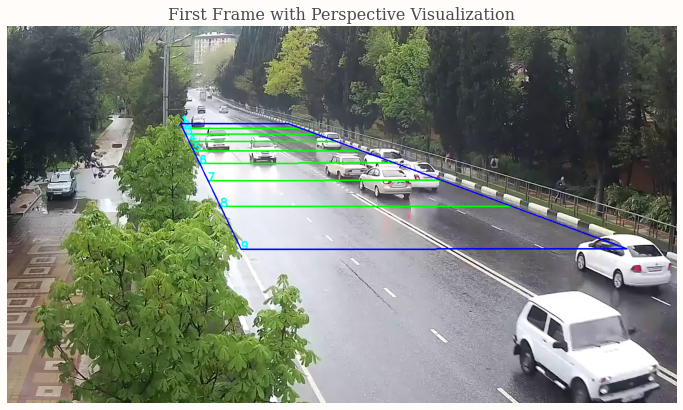

In [17]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# 영상 로드
video_path = SOURCE_VIDEO  # 여기에 영상 경로 입력
cap = cv.VideoCapture(video_path)
ret, frame = cap.read()  # 첫 번째 프레임 읽기

if not ret:
    raise ValueError("영상 로드 실패")

# 데이터 정의 (11번 영상 기준)
image_pts = np.array(image_pts_set[video_number], dtype=np.float32)
world_pts = np.array(world_pts_set[video_number], dtype=np.float32)

# 매퍼 클래스 정의
class World2CamMapper:
    def __init__(self):
        self.M = None

    def find_perspective_transform(self, image_pts, world_pts):
        self.M = cv.getPerspectiveTransform(world_pts.reshape(-1,1,2), image_pts.reshape(-1,1,2))
        return self.M

    def map(self, world_pts):
        if self.M is None:
            raise ValueError("Perspective transform not estimated")
        world_pts = np.asarray(world_pts, dtype=np.float32).reshape(-1, 1, 2)
        return cv.perspectiveTransform(world_pts, self.M).reshape(-1, 2)

# 원근 변환 매퍼 초기화
wmapper = World2CamMapper()
wmapper.find_perspective_transform(image_pts, world_pts)

# 월드 좌표를 8등분하여 이미지 좌표로 변환
A, B, C, D = world_pts
lines_coords_world = []
for i in range(9):
    alpha = i / 8
    start = A + (D - A) * alpha
    end = B + (C - B) * alpha
    lines_coords_world.append((start, end))

lines_coords_image = [wmapper.map([start, end]) for start, end in lines_coords_world]
print(lines_coords_image)
# 영상 첫 번째 프레임에 그리기
for idx, line in enumerate(lines_coords_image):
    pt1 = tuple(line[0].astype(int))
    pt2 = tuple(line[1].astype(int))
    color = (0, 0, 255) if idx in [0,8] else (0, 255, 0)
    cv.line(frame, pt1, pt2, color, 2)
    cv.putText(frame, f"{idx+1}", pt1, cv.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,0), 2)

# 외곽선 그리기
polygon = np.array([image_pts[0], image_pts[1], image_pts[2], image_pts[3]], np.int32)
cv.polylines(frame, [polygon], isClosed=True, color=(255, 0, 0), thickness=2)

# 결과 시각화
plt.figure(figsize=(12, 8))
plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
plt.title("First Frame with Perspective Visualization")
plt.axis('off')
plt.show()

# 영상 리소스 해제
cap.release()

(5, 6)
Point (5~6)


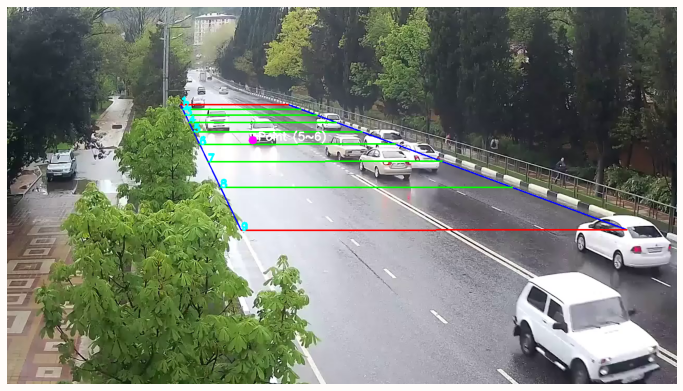

In [18]:
def find_segment(image_point, lines_coords_image):
    point = (float(image_point[0]), float(image_point[1]))
    for idx in range(len(lines_coords_image) - 1):
        line1 = lines_coords_image[idx]
        line2 = lines_coords_image[idx + 1]
        polygon = np.array([line1[0], line1[1], line2[1], line2[0]], dtype=np.float32)
        if cv.pointPolygonTest(polygon, point, False) >= 0:
            return (idx + 1, idx + 2)
    return None

# 좌표 테스트 및 시각화
test_image_point = (469,254)
segment = find_segment(test_image_point, lines_coords_image)
if segment is not None:
    text = f"Point ({segment[0]}~{segment[1]})"
else:
    text = "Outside"
print(segment)
print(text)
# 첫 번째 프레임 위에 영역과 선 그리기
polygon = np.array([image_pts[0], image_pts[1], image_pts[2], image_pts[3]], dtype=np.int32)
cv.polylines(frame, [polygon], isClosed=True, color=(255, 0, 0), thickness=2)

for idx, line in enumerate(lines_coords_image):
    pt1 = tuple(line[0].astype(int))
    pt2 = tuple(line[1].astype(int))
    color = (0, 0, 255) if idx in [0,8] else (0, 255, 0)
    cv.line(frame, pt1, pt2, color, 2)
    cv.putText(frame, f"{idx+1}", pt1, cv.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,0), 2)

# 테스트 점 찍기
cv.circle(frame, (int(test_image_point[0]), int(test_image_point[1])), 8, (255, 0, 255), -1)
cv.putText(frame, text,
           (int(test_image_point[0])+10, int(test_image_point[1])),
           cv.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

# 결과 출력
plt.figure(figsize=(12, 8))
plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

월드 좌표로 변환된 좌표: [     5.5785       110.1]


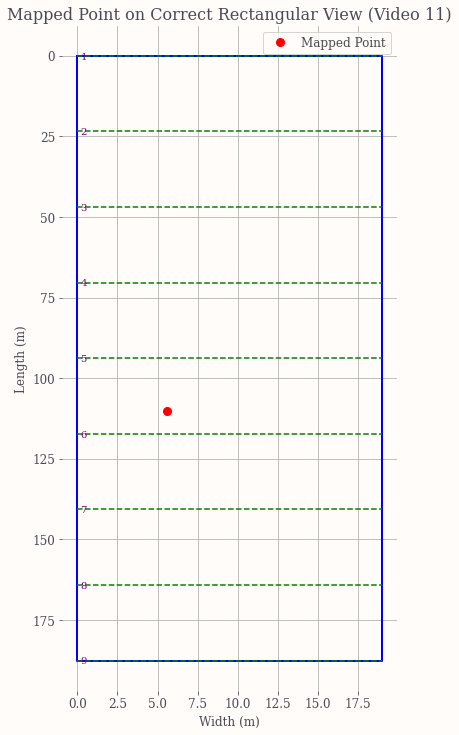

In [24]:
cap.release()
test_image_point = (469,254)
mapped_world_point = mapper.map_to_world([test_image_point])[0]

print("월드 좌표로 변환된 좌표:", mapped_world_point)

rect_width, rect_height = world_pts_set[video_number][2]
rect_image_pts = np.array(world_pts_set[video_number], dtype=np.float32)

# 직사각형으로 변환하는 매퍼 생성
rect_mapper = Cam2WorldMapper()
rect_mapper.find_perspective_transform(image_pts, rect_image_pts)

# 이미지 좌표를 직사각형으로 변환하여 시각화
mapped_rect_point = rect_mapper.map_to_world([test_image_point])[0]

plt.figure(figsize=(6, 12))
plt.plot([0, rect_width, rect_width, 0, 0],
         [0, 0, rect_height, rect_height, 0], 'b-', linewidth=2)

# 8등분 선 그리기
for i in range(9):
    y = i * rect_height / 8
    plt.plot([0, rect_width], [y, y], 'g--')
    plt.text(0.2, y + 1, f"{i+1}", fontsize=10, color='purple')

# 점 찍기
plt.plot(mapped_rect_point[0], mapped_rect_point[1], 'ro', markersize=8, label='Mapped Point')

plt.title("Mapped Point on Correct Rectangular View (Video 11)")
plt.xlabel("Width (m)")
plt.ylabel("Length (m)")
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.show()

In [20]:
import ast

def calculate(x):
    if x == '0':
        return -1,-1
    points = ast.literal_eval(x)[0]
    centerx = points[0]
    undery = points[1]
    return centerx, undery

#a = pd.read_csv(f"detect_PointAndSpeed_좌상단우하단_{video_number}.csv")
a = pd.read_csv(f"detect_all_중앙하단_{video_number}.csv")
instance1 = a['accident_1']
instance2 = a['accident_2']
#([133, 172, 279, 230], 0)
points1 = [calculate(i) for i in instance1]
points2 = [calculate(i) for i in instance2]


In [27]:
import numpy as np
import cv2 as cv

# 영상 불러오기
video_path = SOURCE_VIDEO
cap = cv.VideoCapture(video_path)

# 영상 속성 얻기
h = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
w = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
fps = cap.get(cv.CAP_PROP_FPS)

# 출력 영상 객체 생성
fourcc = cv.VideoWriter_fourcc(*'mp4v')
out = cv.VideoWriter('output_full.mp4', fourcc, fps, (w, h))

# 좌표 데이터 (11번 영상)
image_pts = np.array(image_pts_set[video_number], dtype=np.float32)
world_pts = np.array(world_pts_set[video_number], dtype=np.float32)

# 변환 행렬 설정
M = cv.getPerspectiveTransform(world_pts, image_pts)

# 8등분 선 이미지 좌표 변환
lines_coords_world = []
A, B, C, D = world_pts
for i in range(9):
    alpha = i / 8
    start = A + (D - A) * alpha
    end = B + (C - B) * alpha
    lines_coords_world.append((start, end))

lines_coords_image = [cv.perspectiveTransform(np.array(line, dtype=np.float32).reshape(-1,1,2), M).reshape(-1,2) 
                      for line in lines_coords_world]

# 변환 행렬 설정
# World -> Image (섹터 선 그리기 및 find_segment 용)
M_world_to_image = cv.getPerspectiveTransform(world_pts.reshape(-1,1,2), image_pts.reshape(-1,1,2))
# Image -> World (좌표 변환 및 CSV 저장용)
M_image_to_world = cv.getPerspectiveTransform(image_pts.reshape(-1,1,2), world_pts.reshape(-1,1,2))

# 구간 찾기 함수
def find_segment(image_point, lines_coords_image):
    point = (float(image_point[0]), float(image_point[1]))
    for idx in range(len(lines_coords_image) - 1):
        line1 = lines_coords_image[idx]
        line2 = lines_coords_image[idx + 1]
        polygon = np.array([line1[0], line1[1], line2[1], line2[0]], dtype=np.float32)
        if cv.pointPolygonTest(polygon, point, False) >= 0:
            return (idx + 1, idx + 2)
    return None

# 사용자가 제공한 포인트 리스트 (프레임 수와 동일한 길이 가정)
test_points1 = points1  # 사용자의 포인트 리스트 사용
test_points2 = points2  # 사용자의 포인트 리스트 사용

frame_data_records=[]

frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret or frame_idx >= len(test_points1):
        break

    point1_img = test_points1[frame_idx]
    point2_img = test_points2[frame_idx]
    
    world_point1_img, world_point2_img = None, None # 월드 좌표 초기화

    if point1_img is not None and len(point1_img) == 2:
         try:
              point1_img_np = np.array([[point1_img]], dtype=np.float32)
              # perspectiveTransform 결과는 (1, 1, 2) 형태이므로 [0][0]으로 추출
              world_point1 = cv.perspectiveTransform(point1_img_np, M_image_to_world)[0][0]
         except Exception as e:
              print(f"Frame {frame_idx}: Error transforming point1 {point1_img} to world coords: {e}")
              world_point1 = None # 오류 시 None 처리

    if point2_img is not None and len(point2_img) == 2:
         try:
              point2_img_np = np.array([[point2_img]], dtype=np.float32)
              world_point2 = cv.perspectiveTransform(point2_img_np, M_image_to_world)[0][0]
         except Exception as e:
              print(f"Frame {frame_idx}: Error transforming point2 {point2_img} to world coords: {e}")
              world_point2 = None

    # 영역 및 선 그리기
    polygon = np.array([image_pts[0], image_pts[1], image_pts[2], image_pts[3]], dtype=np.int32)
    cv.polylines(frame, [polygon], True, (255, 0, 0), 2)

    for idx, line in enumerate(lines_coords_image):
        pt1, pt2 = tuple(line[0].astype(int)), tuple(line[1].astype(int))
        color = (0, 0, 255) if idx in [0,8] else (0, 255, 0)
        cv.line(frame, pt1, pt2, color, 2)

    # 포인트와 구간 찾기
    segment1 = find_segment(point1_img, lines_coords_image)
    segment2 = find_segment(point2_img, lines_coords_image)

    # --- 현재 프레임 데이터 기록 (딕셔너리 형태) ---
    record = {
        'Frame': frame_idx,
        'Point1_World_X': world_point1[0] if world_point1 is not None else None, # 월드 X 좌표
        'Point1_World_Y': world_point1[1] if world_point1 is not None else None, # 월드 Y 좌표
        'Point1_Sector': segment1, # 섹터 정보 (이미지 기준)
        'Point2_World_X': world_point2[0] if world_point2 is not None else None, # 월드 X 좌표
        'Point2_World_Y': world_point2[1] if world_point2 is not None else None, # 월드 Y 좌표
        'Point2_Sector': segment2  # 섹터 정보 (이미지 기준)
    }
    frame_data_records.append(record) # 리스트에 딕셔너리 추가
    ######

    if segment1:
        cv.circle(frame, (int(point1_img[0]), int(point1_img[1])), 8, (255, 0, 255), -1)
        cv.putText(frame, f"Seg: {segment1[0]}-{segment1[1]}",
                   (int(point1_img[0])+10, int(point1_img[1])-10),
                   cv.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    else:
        cv.circle(frame, (int(point1_img[0]), int(point1_img[1])), 8, (0, 0, 255), -1)
        cv.putText(frame, "Outside",
                   (int(point1_img[0])+10, int(point1_img[1])-10),
                   cv.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
    if segment2:
        cv.circle(frame, (int(point2_img[0]), int(point2_img[1])), 8, (255, 0, 255), -1)
        cv.putText(frame, f"Seg: {segment2[0]}-{segment2[1]}",
                   (int(point2_img[0])+10, int(point2_img[1])-10),
                   cv.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    else:
        cv.circle(frame, (int(point2_img[0]), int(point2_img[1])), 8, (0, 0, 255), -1)
        cv.putText(frame, "Outside",
                   (int(point2_img[0])+10, int(point2_img[1])-10),
                   cv.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    # 결과 영상에 저장
    out.write(frame)
    frame_idx += 1

# 자원 해제
cap.release()
out.release()

df = pd.DataFrame(frame_data_records)
csv_filename = f'sector_data_pandas_{video_number}.csv'
df.to_csv(csv_filename, index=False, encoding='utf-8-sig')


print("output_grid.mp4")


output_grid.mp4


In [ ]:
import numpy as np
import cv2 as cv

# 영상 설정
video_path = SOURCE_VIDEO
cap = cv.VideoCapture(video_path)
ret, frame = cap.read()

if not ret:
    raise ValueError("영상 로드 실패")

# 영상 크기와 FPS 설정
rect_width, rect_height = 400, 1200  # 시각화용 직사각형 크기
fps = cap.get(cv.CAP_PROP_FPS)

# 출력 영상 설정
fourcc = cv.VideoWriter_fourcc(*'mp4v')
out = cv.VideoWriter('rect_output.mp4', fourcc, fps, (rect_width, rect_height))

# 원근 변환 설정 (이미지 좌표 → 월드 좌표)
image_pts = np.array(image_pts_set[video_number], dtype=np.float32)
world_pts = np.array(world_pts_set[video_number], dtype=np.float32)

# 이미지 좌표를 실제 월드 좌표로 변환할 행렬
M_inv = cv.getPerspectiveTransform(image_pts, world_pts)

# 직사각형 시각화 변환 행렬 (월드 좌표 → 시각화 직사각형 좌표)
visual_rect_pts = np.array([(0,0),(rect_width,0),(rect_width,rect_height),(0,rect_height)], dtype=np.float32)
M_rect = cv.getPerspectiveTransform(world_pts, visual_rect_pts)

# 실제 사용할 points 리스트 (이미지 좌표)
test_points1 = points1  # 사용자의 포인트 리스트 사용
test_points2 = points2  # 사용자의 포인트 리스트 사용

for point1_img, point2_img in zip(test_points1, test_points2):
    # 이미지 좌표 → 월드 좌표로 변환
    world_point1_img = cv.perspectiveTransform(np.array([[point1_img]], dtype=np.float32), M_inv)[0][0]
    world_point2_img = cv.perspectiveTransform(np.array([[point2_img]], dtype=np.float32), M_inv)[0][0]

    # 월드 좌표 → 시각화 직사각형 좌표로 변환
    rect_point1_img = cv.perspectiveTransform(np.array([[world_point1_img]], dtype=np.float32), M_rect)[0][0]
    rect_point2_img = cv.perspectiveTransform(np.array([[world_point2_img]], dtype=np.float32), M_rect)[0][0]
    # 빈 직사각형 이미지 생성
    rect_frame = np.ones((rect_height, rect_width, 3), dtype=np.uint8) * 255


    # 외곽선 및 8등분선 그리기
    for i in range(9):
        y = int(i * rect_height / 8)
        color = (0, 0, 255) if i in [0, 8] else (0, 255, 0)
        cv.line(rect_frame, (0, y), (rect_width, y), color, 2)
        cv.putText(rect_frame, f'{i+1}', (5, y+20), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    cv.rectangle(rect_frame, (0, 0), (rect_width-1, rect_height-1), (255, 0, 0), 2)

    # 점 찍기
    cv.circle(rect_frame, (int(rect_point1_img[0]), int(rect_point1_img[1])), 10, (255, 0, 255), -1)
    cv.circle(rect_frame, (int(rect_point2_img[0]), int(rect_point2_img[1])), 10, (0, 0, 255), -1)

    # 영상 프레임 추가
    out.write(rect_frame)

# 영상 종료 및 저장
cap.release()
out.release()

print("rect_output.mp4")


rect_output.mp4
